In [1]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

ROOT_DIR /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations


In [2]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

dbFile = f'{MACHINE}-fullExploreDataset.csv'
print(dbFile)
xtimeDB = pd.read_csv(ROOT_DIR+'/databases/'+dbFile)

# drop cg_nas and cfd_rodinia
xtimeDB = xtimeDB[(xtimeDB['progname'] != 'cg_nas') & (xtimeDB['progname'] != 'cfd_rodinia')]

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations
ruby-fullExploreDataset.csv


In [3]:
# normalize the xtime space to be between (optimal-2*baseline, optimal)
print(xtimeDB.columns)

numthreads = 112 if MACHINE == 'ruby' else 160

for col in list(xtimeDB.columns):
	uniq = list(xtimeDB[col].unique())
	print(col, uniq)

baselines = xtimeDB[(xtimeDB['OMP_NUM_THREADS'] == numthreads)&
										(xtimeDB['OMP_PROC_BIND'] == 'close')&
										(xtimeDB['OMP_PLACES'] == 'threads')&
										(xtimeDB['OMP_SCHEDULE'] == 'static') ]
print('baselines')
print(baselines)

optimals = xtimeDB.groupby(['progname', 'probsize'])['xtime'].min().reset_index()
print('optimals')
print(optimals)

baselines = baselines.set_index(['progname', 'probsize'])
optimals = optimals.set_index(['progname', 'probsize'])

baselines['max'] = optimals['xtime']+(2*(baselines['xtime']-optimals['xtime']))
baselines['min'] = optimals['xtime']

print(baselines)

norm = baselines[['min', 'max']]
print(norm)


Index(['progname', 'probsize', 'OMP_NUM_THREADS', 'OMP_PROC_BIND', 'OMP_PLACES', 'OMP_SCHEDULE', 'xtime', 'stddev'], dtype='object')
progname ['bt_nas', 'ft_nas', 'hpcg', 'lulesh']
probsize ['lrgprob', 'medprob', 'smlprob']
OMP_NUM_THREADS [4, 8, 14, 28, 42, 56, 70, 84, 98, 112]
OMP_PROC_BIND ['close', 'spread']
OMP_PLACES ['cores', 'sockets', 'threads']
OMP_SCHEDULE ['dynamic,1', 'dynamic,128', 'dynamic,256', 'dynamic,32', 'dynamic,512', 'dynamic,64', 'dynamic,8', 'guided,1', 'guided,128', 'guided,256', 'guided,32', 'guided,512', 'guided,64', 'guided,8', 'static', 'static,1', 'static,128', 'static,256', 'static,32', 'static,512', 'static,64', 'static,8']
xtime [4500.0, 3177.24, 3896.72, 3924.0866666666666, 3442.903333333333, 3175.4066666666663, 3899.573333333333, 3926.5733333333337, 3393.346666666667, 3183.67, 3188.813333333333, 3914.0633333333335, 3925.09, 3463.33, 3195.14, 3896.0466666666666, 3954.35, 3417.0933333333337, 3194.7166666666667, 3881.7466666666655, 3953.786666666667, 341

In [4]:
# Now let's normalize all the data

normed = xtimeDB.copy(deep=True).set_index(['progname', 'probsize'])
normed = normed.drop(['stddev'], axis=1)

print(normed)

normed.loc[:, 'xtime'] = (normed['xtime']-norm['min'])/(norm['max']-norm['min'])

# for the really long xtimes, cap them out at 1
normed.loc[normed['xtime'] > 1, 'xtime'] = 1

# now reverse the scale so 0 is worst and 1 is best
normed.loc[:, 'xtime'] = 1 - normed['xtime']

print(normed) 

                   OMP_NUM_THREADS OMP_PROC_BIND OMP_PLACES OMP_SCHEDULE        xtime
progname probsize                                                                    
bt_nas   lrgprob                 4         close      cores    dynamic,1  4500.000000
         lrgprob                 4         close      cores  dynamic,128  4500.000000
         lrgprob                 4         close      cores  dynamic,256  4500.000000
         lrgprob                 4         close      cores   dynamic,32  4500.000000
         lrgprob                 4         close      cores  dynamic,512  4500.000000
...                            ...           ...        ...          ...          ...
lulesh   smlprob               112        spread    threads   static,256    26.540111
         smlprob               112        spread    threads    static,32    25.984873
         smlprob               112        spread    threads   static,512    26.962077
         smlprob               112        spread    th

In [5]:
# now that we have the normalized data, let's plot it

df = normed.copy(deep=True)

df['OMP_SCHED_PROC_BIND'] = list(zip(normed['OMP_SCHEDULE'], normed['OMP_PROC_BIND']))
df['OMP_NUM_THREADS_PLACES'] = list(zip(normed['OMP_NUM_THREADS'], normed['OMP_PLACES']))

df = df.drop(['OMP_NUM_THREADS', 'OMP_PROC_BIND', 'OMP_PLACES', 'OMP_SCHEDULE'], axis=1).reset_index()

print(df)

uniqA = list(df['OMP_SCHED_PROC_BIND'].unique())
uniqB = list(df['OMP_NUM_THREADS_PLACES'].unique())
print(len(uniqA), uniqA)
print(len(uniqB), uniqB)

      progname probsize     xtime   OMP_SCHED_PROC_BIND OMP_NUM_THREADS_PLACES
0       bt_nas  lrgprob  0.000000    (dynamic,1, close)             (4, cores)
1       bt_nas  lrgprob  0.000000  (dynamic,128, close)             (4, cores)
2       bt_nas  lrgprob  0.000000  (dynamic,256, close)             (4, cores)
3       bt_nas  lrgprob  0.000000   (dynamic,32, close)             (4, cores)
4       bt_nas  lrgprob  0.000000  (dynamic,512, close)             (4, cores)
...        ...      ...       ...                   ...                    ...
15835   lulesh  smlprob  0.522546  (static,256, spread)         (112, threads)
15836   lulesh  smlprob  0.534771   (static,32, spread)         (112, threads)
15837   lulesh  smlprob  0.513256  (static,512, spread)         (112, threads)
15838   lulesh  smlprob  0.529968   (static,64, spread)         (112, threads)
15839   lulesh  smlprob  0.469998    (static,8, spread)         (112, threads)

[15840 rows x 5 columns]
44 [('dynamic,1', 'close')

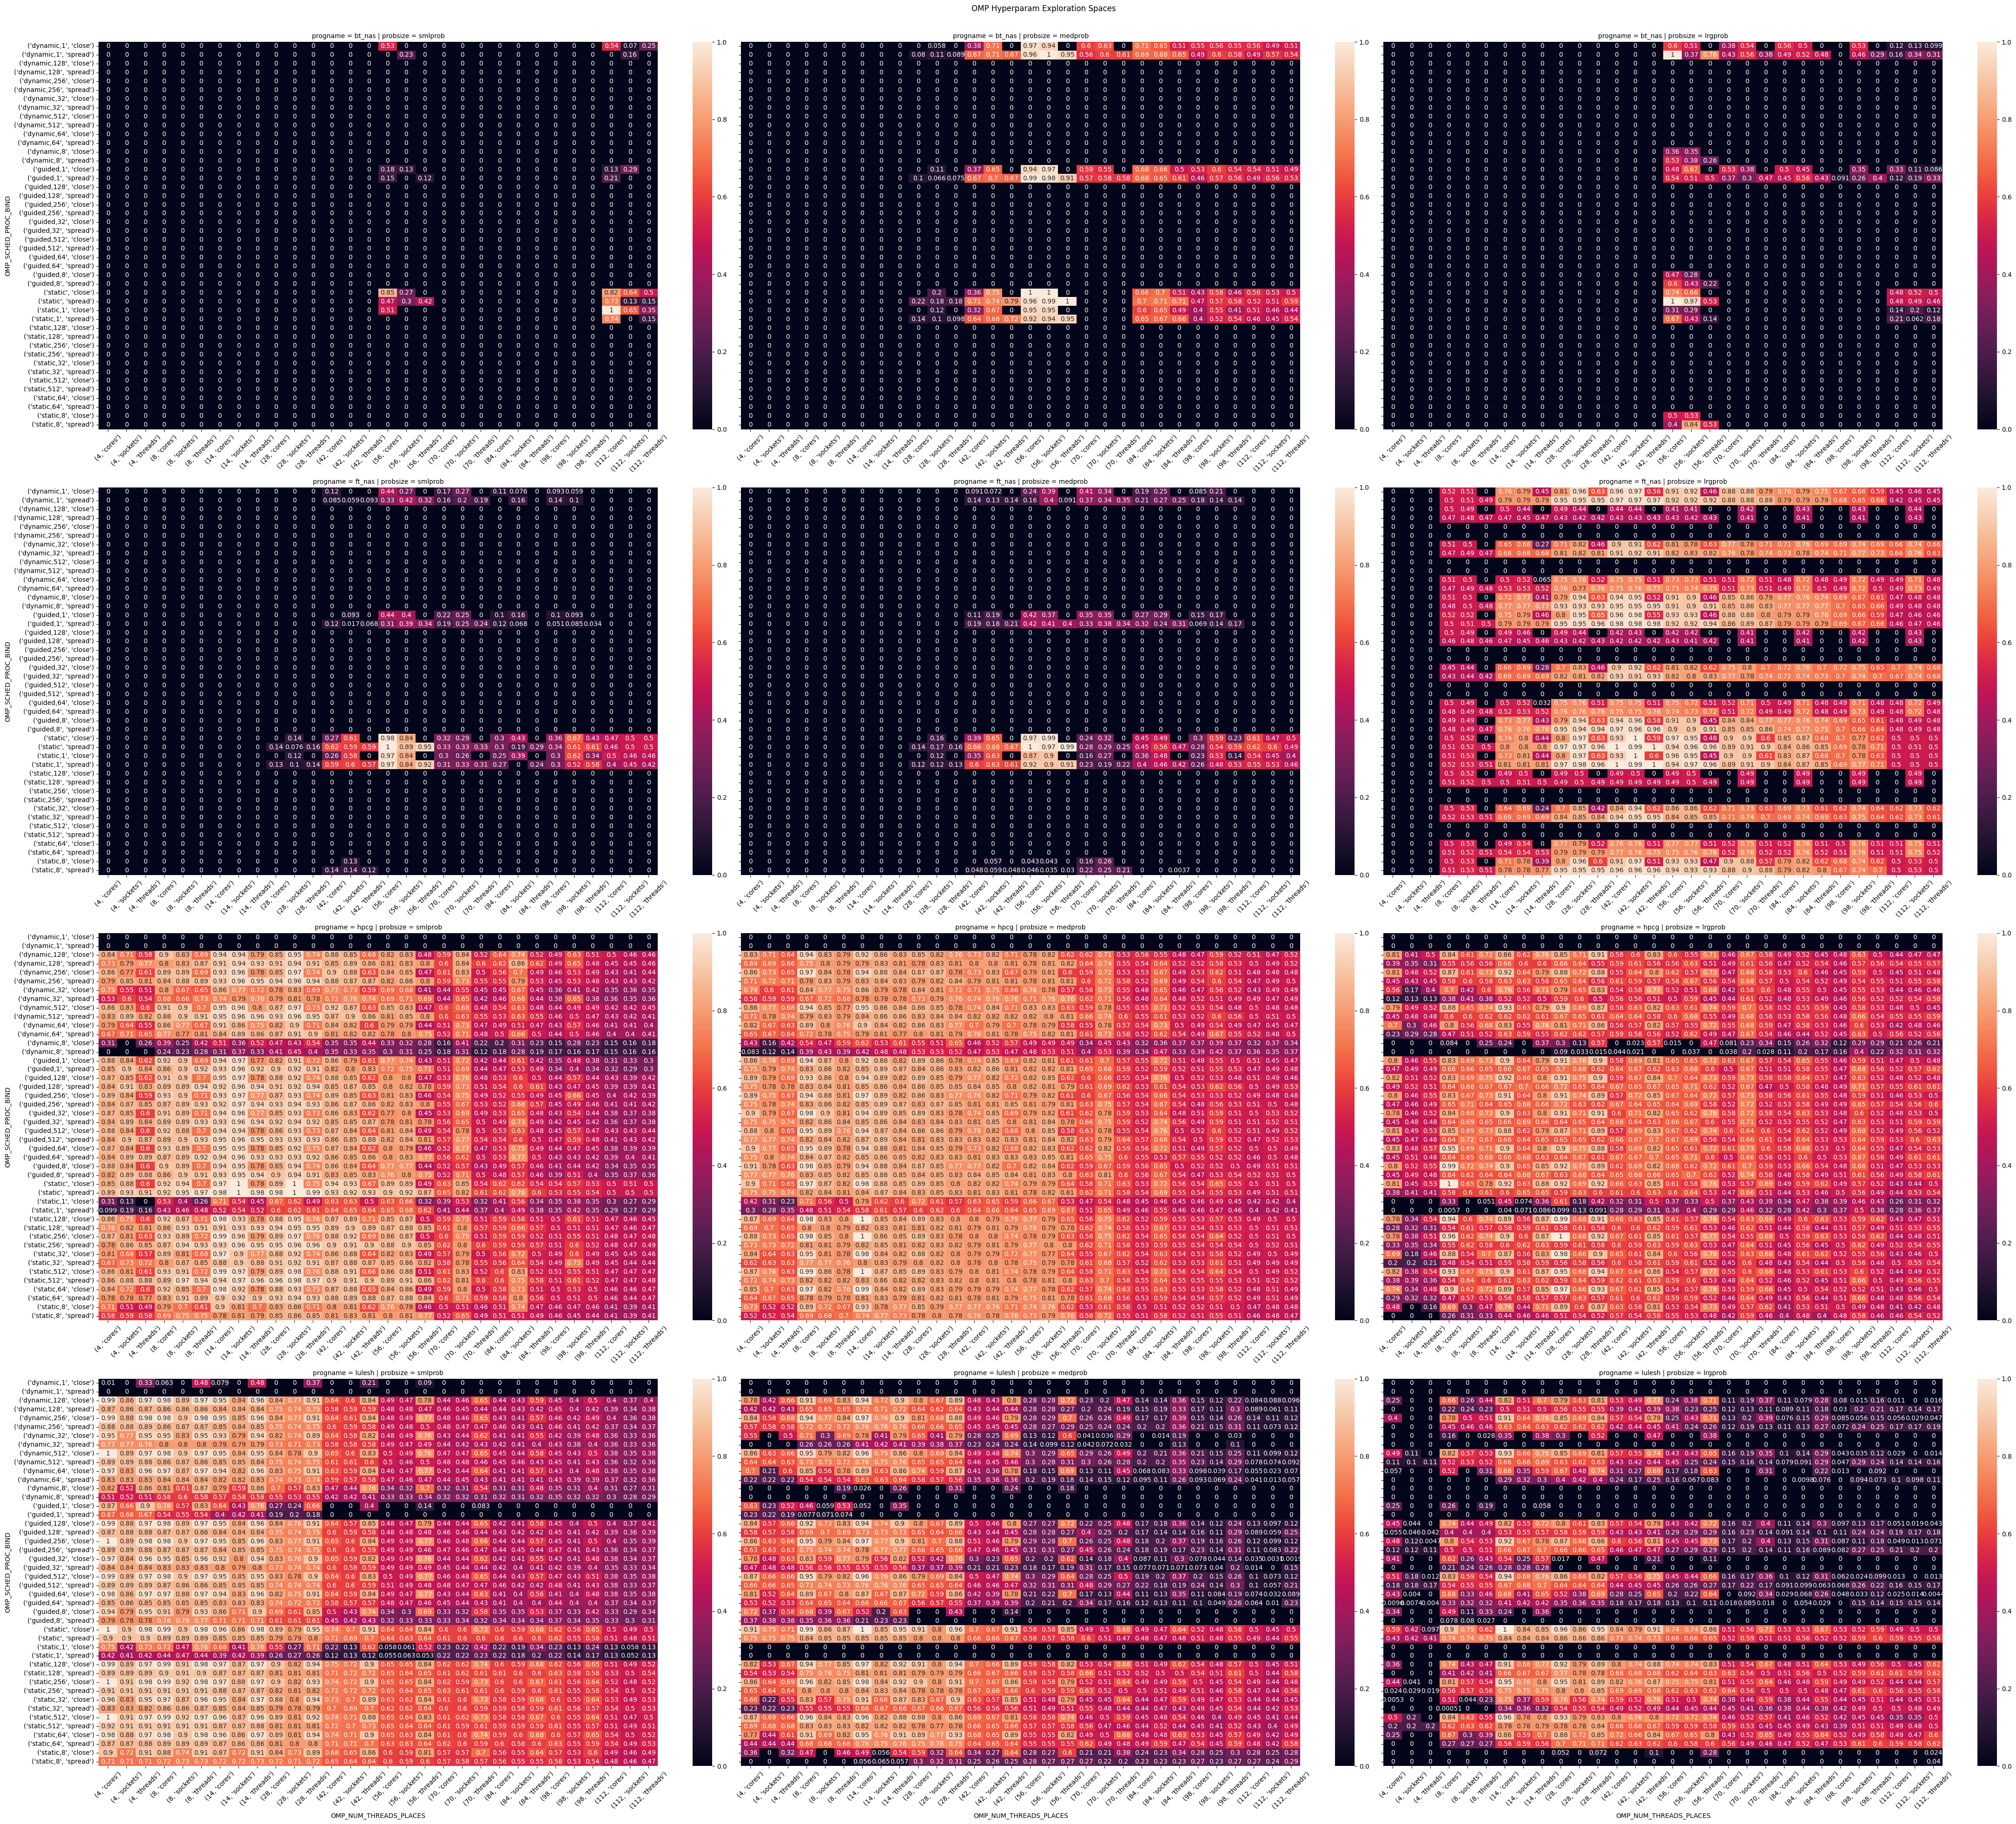

In [20]:

def drawHeatmap(*args, **kwargs):
	data = kwargs.pop('data').copy(deep=True)
	data = data.drop(['probsize'], axis=1)
	data = data.drop(['progname'], axis=1)
	data = data.pivot(index='OMP_SCHED_PROC_BIND', columns='OMP_NUM_THREADS_PLACES', values='xtime')
	# plot the good values
	ax = sns.heatmap(data, **kwargs)
	# plot the never found values
	#sns.heatmap(data, mask=data >= 0, cmap=plt.get_cmap('binary'), vmin=-1, vmax=-1, ax=ax, cbar=False)

g = sns.FacetGrid(df, row='progname', col='probsize', col_order=probsizes, palette='flare', height=10, aspect=1.5)
g.map_dataframe(drawHeatmap, annot=True, vmin=0.0, vmax=1.0, cbar=True)


for ax in g.axes.flatten():
	ax.tick_params(axis='x', labelbottom=True, labelrotation=45)

plt.tight_layout()

g.fig.subplots_adjust(top=0.96)
g.fig.suptitle(f'OMP Hyperparam Exploration Spaces')

plt.show()